In [31]:
import xarray as xr
import pandas as pd
%matplotlib inline

import datetime as dt

import numpy as np

from rasterio.mask import mask
import rasterio
from rasterio import features

import rasterio.features
from shapely.geometry import shape

In [32]:
NDVI_EVI= xr.open_dataset('/g/data/oe9/user/rg6346/NDVI_stack/MOD13A1_NDVI_EVI_2000.nc')
NDVI_EVI=NDVI_EVI.rename({'__xarray_dataarray_variable__': 'ndvi'})

### Masking shapefile

In [33]:
NDVI_EVI

<xarray.Dataset>
Dimensions:  (band: 3, time: 20, x: 3346, y: 3147)
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 -24.59 -24.59 -24.6 -24.6 -24.6 -24.61 -24.61 ...
  * x        (x) float64 138.6 138.6 138.6 138.6 138.6 138.6 138.6 138.6 ...
  * time     (time) datetime64[ns] 2000-02-18 2000-03-05 2000-03-21 ...
Data variables:
    ndvi     (time, band, y, x) int16 ...

In [34]:
import fiona
import rasterio
import rasterio.mask

# create geometry coordinates of shapefile boundary 
# open the MDB shapefile 
with fiona.open("/home/563/sl1412/rainfall/mdb_boundary/mdb_boundary.shp", "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]
# geoms

In [35]:
# mask the SPI raster based on geoms 
with rasterio.open("/g/data/oe9/user/rg6346/NDVI_16D_500M/MOD13A1_005_NDVI_2000-02-18.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, geoms,
                                                        crop=True)
    out_meta = src.meta.copy()

In [36]:
out_meta

{'count': 3,
 'crs': CRS({'init': 'epsg:4326'}),
 'driver': 'GTiff',
 'dtype': 'int16',
 'height': 3147,
 'nodata': None,
 'transform': Affine(0.004162008945837755, 0.0, 138.5657638337764,
       0.0, -0.004162008945837755, -24.58498684306362),
 'width': 3346}

In [37]:
out_transform # Affine transform variable used for rasterise the geoms 

Affine(0.004162008945837755, 0.0, 138.5657638337764,
       0.0, -0.004162008945837755, -24.58498684306362)

In [38]:
shape_data = NDVI_EVI.ndvi.isel(band=1,time=0).shape
shape_data # shape of the raster (no. of col and no. of rows)

(3147, 3346)

In [39]:
# create masking array 
mask = xr.DataArray(
    features.rasterize(geoms, out_shape=shape_data, transform=out_transform, all_touched= False),
    coords=NDVI_EVI.ndvi.isel(band=1,time=0).coords,
)
mask

<xarray.DataArray (y: 3147, x: 3346)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
    band     int64 2
  * y        (y) float64 -24.59 -24.59 -24.6 -24.6 -24.6 -24.61 -24.61 ...
  * x        (x) float64 138.6 138.6 138.6 138.6 138.6 138.6 138.6 138.6 ...
    time     datetime64[ns] 2000-02-18

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


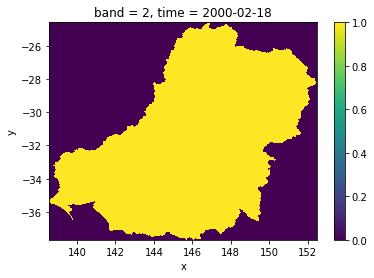

In [40]:
mask.plot.imshow()

In [42]:
subset = NDVI_EVI.where(mask, drop=True)
subset

<xarray.Dataset>
Dimensions:  (band: 3, time: 20, x: 3344, y: 3147)
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 -24.59 -24.59 -24.6 -24.6 -24.6 -24.61 -24.61 ...
  * x        (x) float64 138.6 138.6 138.6 138.6 138.6 138.6 138.6 138.6 ...
  * time     (time) datetime64[ns] 2000-02-18 2000-03-05 2000-03-21 ...
Data variables:
    ndvi     (time, band, y, x) float64 nan nan nan nan nan nan nan nan nan ...

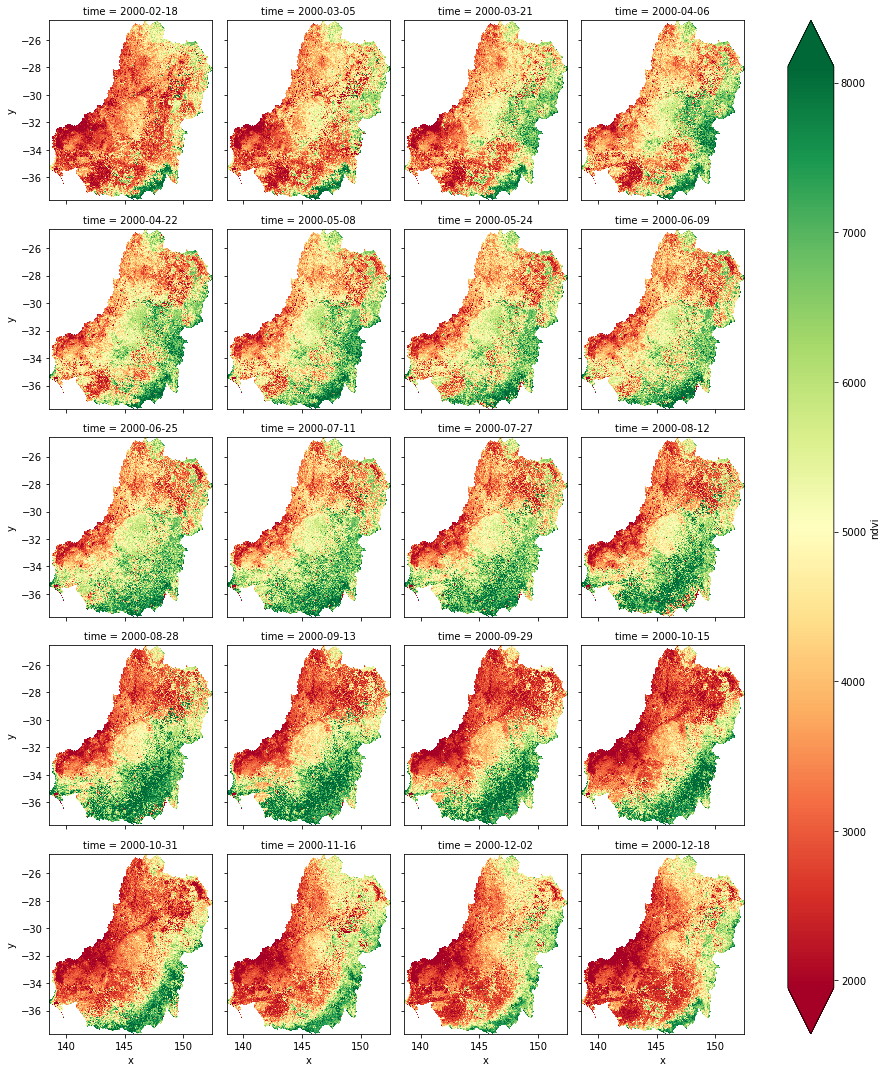

In [43]:
subset.ndvi.isel(band=1).plot.imshow(col='time', robust = True, col_wrap=4, cmap = 'RdYlGn')